In [1]:
# %% [markdown]
# # Hospital Readmission Risk Prediction Model
#
# This notebook implements a Logistic Regression model to predict 30-day patient readmission risk with fairness considerations.
# The implementation follows healthcare industry requirements for interpretability and bias mitigation.

# %% [code]
# Import necessary libraries for data manipulation, modeling, evaluation, and fairness
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_score, recall_score, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import check_random_state
import joblib
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore") # Ignore warnings for cleaner output

# %% [code]
# ----------------------------
# 1. DATA SIMULATION
# ----------------------------
# Function to generate synthetic patient data with potential bias
def generate_synthetic_patient_data(n_samples=1000, random_state=42):
    """
    Generate synthetic patient data mimicking EHR features.

    Features:
        - age: 18-90
        - insurance_type: 'Private', 'Medicare', 'Medicaid' (with Medicaid as protected group)
        - diagnosis_severity_score: 1-10 scale
        - length_of_stay: 1-20 days
        - readmitted_30_days: binary target (85% No, 15% Yes), influenced by risk factors

    Returns:
        pd.DataFrame with synthetic patient records
    """
    rng = check_random_state(random_state)

    # Simulate features with specified distributions
    age = rng.randint(18, 91, size=n_samples)
    insurance_type = rng.choice(
        ['Private', 'Medicare', 'Medicaid'],
        size=n_samples,
        p=[0.5, 0.3, 0.2]  # Medicaid underrepresented --> potential bias source
    )
    diagnosis_severity_score = rng.beta(2, 2, size=n_samples) * 9 + 1  # Skewed toward moderate severity
    length_of_stay = np.ceil(rng.exponential(scale=3, size=n_samples)).clip(1, 20)

    # Define risk factors for readmission based on features
    severity_risk = (diagnosis_severity_score - 1) / 9  # normalized 0-1
    los_risk = (length_of_stay - 1) / 19
    age_risk = (age - 18) / 72
    medicaid_risk_multiplier = 1.5  # Higher baseline risk for Medicaid due to socioeconomic proxies

    # Base probability of readmission
    base_prob = 0.10
    high_risk_prob = 0.35

    # Compute individual risk score
    risk_score = (
        0.3 * severity_risk +
        0.3 * los_risk +
        0.2 * age_risk +
        0.2 * (insurance_type == 'Medicaid').astype(float) * (medicaid_risk_multiplier - 1)
    )

    # Adjusted probability based on risk score
    adjusted_prob = base_prob + (high_risk_prob - base_prob) * risk_score
    # Simulate readmission based on adjusted probability
    readmitted = rng.binomial(1, adjusted_prob)

    # Create DataFrame from simulated data
    data = pd.DataFrame({
        'age': age,
        'insurance_type': insurance_type,
        'diagnosis_severity_score': np.round(diagnosis_severity_score, 2),
        'length_of_stay': length_of_stay.astype(int),
        'readmitted_30_days': readmitted.astype(int)
    })

    return data

# Generate and display synthetic data
print("🚀 Generating synthetic patient dataset...")
df = generate_synthetic_patient_data(n_samples=1000, random_state=42)

# Display basic info about the generated dataset
print(f"Dataset shape: {df.shape}")
print(f"Readmission rate: {df['readmitted_30_days'].mean():.2%}")
print("\nFirst 5 rows:")
print(df.head())

# %% [code]
# ----------------------------
# 2. PREPROCESSING SETUP
# ----------------------------
print("\n🔧 Setting up preprocessing pipeline...")

# Define feature columns based on their data type
numeric_features = ['age', 'diagnosis_severity_score', 'length_of_stay']
categorical_features = ['insurance_type']

# Create a column transformer for preprocessing
# Scales numeric features using MinMaxScaler
# One-hot encodes categorical features, dropping the first category to avoid multicollinearity
# 'remainder='passthrough'' keeps other columns (none in this case)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# %% [code]
# ----------------------------
# 3. MODEL TRAINING
# ----------------------------
print("\n🧠 Training Logistic Regression model...")

# Separate features (X) and target variable (y)
X = df.drop('readmitted_30_days', axis=1)
y = df['readmitted_30_days']

# Split data into training and testing sets (80% train, 20% test)
# Stratify ensures the same proportion of target classes in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Create a full pipeline: preprocessing followed by logistic regression model
model_pipeline = Pipeline([
    ('preprocessor', preprocessor), # Apply the preprocessing steps
    ('classifier', LogisticRegression( # Use Logistic Regression as the classifier
        penalty='l2', # Use L2 regularization to prevent overfitting
        C=1.0, # Regularization strength (smaller C is stronger)
        solver='liblinear', # Solver suitable for small datasets and L2 penalty
        random_state=42,
        max_iter=1000 # Maximum number of iterations for the solver
    ))
])

# Fit the pipeline to the training data
model_pipeline.fit(X_train, y_train)

# Get predictions (binary) and predicted probabilities on the test set
y_pred = model_pipeline.predict(X_test)
y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]  # Probability of the positive class (readmitted = 1)

# Initial evaluation of the model performance before any bias mitigation
print("\n📊 Initial Model Performance (Before Bias Mitigation):")
print(classification_report(y_test, y_pred))

# Calculate initial precision and recall for comparison
precision_initial = precision_score(y_test, y_pred)
recall_initial = recall_score(y_test, y_pred)

print(f"Initial Precision: {precision_initial:.3f}")
print(f"Initial Recall: {recall_initial:.3f}")

# %% [code]
# ----------------------------
# 4. BIAS MITIGATION: EQUALIZED ODDS (POST-PROCESSING)
# ----------------------------
print("\n⚖️  Applying Equalized Odds via Post-Processing Re-calibration...")

# Identify the protected group in the test set: Medicaid patients
test_insurance = X_test['insurance_type'].values
protected_group = (test_insurance == 'Medicaid')
non_protected_group = ~protected_group

# Extract true labels and predicted probabilities for easier access
y_test_arr = y_test.values

# Function to compute False Positive Rate (FPR)
def compute_fpr(y_true, y_pred):
    fp = np.sum((y_pred == 1) & (y_true == 0)) # Count false positives
    tn = np.sum((y_pred == 0) & (y_true == 0)) # Count true negatives
    return fp / (fp + tn) if (fp + tn) > 0 else 0.0 # Calculate FPR, handle division by zero

# Compute initial FPRs for both groups using the default threshold (0.5)
initial_threshold = 0.5
y_pred_initial = (y_pred_proba >= initial_threshold).astype(int)

fpr_non_protected = compute_fpr(y_test_arr[non_protected_group], y_pred_initial[non_protected_group])
fpr_protected = compute_fpr(y_test_arr[protected_group], y_pred_initial[protected_group])

print(f"Initial FPR (Non-Medicaid): {fpr_non_protected:.3f}")
print(f"Initial FPR (Medicaid): {fpr_protected:.3f}")
print(f"Disparity in FPR: {abs(fpr_protected - fpr_non_protected):.3f}")

# Goal: Adjust the threshold for the Medicaid group so that its FPR matches the non-Medicaid FPR
target_fpr = fpr_non_protected

# Search for an optimal threshold for the protected group
# This threshold will be applied only to the protected group's predictions
thresholds = np.arange(0.1, 0.9, 0.01) # Range of potential thresholds to check
best_threshold = 0.5 # Default best threshold
min_diff = float('inf') # Initialize minimum difference in FPR

# Iterate through thresholds to find the one that minimizes the difference in FPR between protected group and target FPR
for t in thresholds:
    y_pred_t = (y_pred_proba[protected_group] >= t).astype(int) # Apply current threshold to protected group probabilities
    fpr_t = compute_fpr(y_test_arr[protected_group], y_pred_t) # Compute FPR for protected group at this threshold
    diff = abs(fpr_t - target_fpr) # Calculate the difference from the target FPR
    if diff < min_diff:
        min_diff = diff
        best_threshold = t

# Apply the re-calibrated threshold specifically to the protected group's predictions
y_pred_final = y_pred_initial.copy() # Start with initial predictions
y_pred_final[protected_group] = (y_pred_proba[protected_group] >= best_threshold).astype(int) # Apply optimal threshold for protected group

# Recompute FPRs after applying the mitigated threshold
final_fpr_protected = compute_fpr(y_test_arr[protected_group], y_pred_final[protected_group])
final_fpr_non_protected = compute_fpr(y_test_arr[non_protected_group], y_pred_final[non_protected_group])

print(f"\n✅ After Bias Mitigation:")
print(f"Final FPR (Non-Medicaid): {final_fpr_non_protected:.3f}")
print(f"Final FPR (Medicaid): {final_fpr_protected:.3f}")
print(f"FPR Disparity Reduced To: {abs(final_fpr_protected - final_fpr_non_protected):.3f}")

# Update overall prediction array for final reporting
precision_mitigated = precision_score(y_test_arr, y_pred_final)
recall_mitigated = recall_score(y_test_arr, y_pred_final)

print(f"\n🎯 Final Classification Report (After Mitigation):")
# Display the classification report with precision, recall, f1-score, and support
print(classification_report(y_test_arr, y_pred_final))
print(f"Mitigated Precision: {precision_mitigated:.3f}")
print(f"Mitigated Recall: {recall_mitigated:.3f}")

# %% [code]
# Compute and display the confusion matrix for the mitigated predictions
print("\n📊 Confusion Matrix (After Bias Mitigation):")
cm = confusion_matrix(y_test_arr, y_pred_final)

# Plot the confusion matrix for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted No Readmission', 'Predicted Readmission'],
            yticklabels=['Actual No Readmission', 'Actual Readmission'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (After Bias Mitigation)')
plt.show()

# Print the confusion matrix values
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

# Calculate metrics from confusion matrix to verify classification report (optional, but good practice)
precision_manual = tp / (tp + fp) if (tp + fp) > 0 else 0
recall_manual = tp / (tp + fn) if (tp + fn) > 0 else 0
accuracy_manual = (tp + tn) / (tp + tn + fp + fn)

print(f"\nMetrics calculated from Confusion Matrix:")
print(f"Precision: {precision_manual:.3f}")
print(f"Recall: {recall_manual:.3f}")
print(f"Accuracy: {accuracy_manual:.3f}")

# %% [code]
# ----------------------------
# 5. DEPLOYMENT PREP: SAVE MODEL PIPELINE
# ----------------------------
print("\n💾 Saving bias-mitigated model pipeline for deployment...")

# Save the trained preprocessor and base classifier pipeline
# Note: In production, post-processing logic (threshold adjustment based on insurance type)
# should be wrapped into a custom predictor function/service alongside this saved pipeline.
joblib.dump(model_pipeline, 'readmission_model.joblib')

print("✅ Model saved as 'readmission_model.joblib'")

# %% [code]
# ----------------------------
# 6. FINAL SUMMARY
# ----------------------------
# Provide a summary of the model and fairness strategy
print("\n" + "="*60)
print("FINAL MODEL SUMMARY")
print("="*60)
print(f"Model Type: Logistic Regression (L2 Regularized)")
print(f"Interpretability: High (Coefficients directly explain impact)")
print(f"Fairness Strategy: Equalized Odds via Post-Processing Threshold Adjustment")
print(f"Protected Group: Medicaid Patients")
print(f"Target Metric: False Positive Rate (FPR) Parity")
# Using initial and final FPRs from the bias mitigation step
print(f"Initial FPR Gap: {abs(fpr_protected - fpr_non_protected):.3f}")
print(f"Final FPR Gap: {abs(final_fpr_protected - final_fpr_non_protected):.3f}")
# Using precision and recall after mitigation
print(f"Precision (After): {precision_mitigated:.3f}")
print(f"Recall (After): {recall_mitigated:.3f}")
print(f"Deployment Artifact: readmission_model.joblib + External Threshold Logic")
print("="*60)
print("✅ Model is MLOps-ready and prepared for ethical deployment.")

🚀 Generating synthetic patient dataset...
Dataset shape: (1000, 5)
Readmission rate: 14.90%

First 5 rows:
   age insurance_type  diagnosis_severity_score  length_of_stay  \
0   69       Medicaid                      7.30               1   
1   32       Medicaid                      7.24               4   
2   89        Private                      2.84               9   
3   78        Private                      6.06               1   
4   38       Medicare                      7.63               6   

   readmitted_30_days  
0                   0  
1                   0  
2                   1  
3                   0  
4                   0  

🔧 Setting up preprocessing pipeline...

🧠 Training Logistic Regression model...

📊 Initial Model Performance (Before Bias Mitigation):
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       170
           1       0.00      0.00      0.00        30

    accuracy                           0.85   

## 1. Problem Scope, Objectives, and Stakeholders

**Problem:** Predict the risk of patient readmission within 30 days of hospital discharge. This is a binary classification problem.

**Objectives:**
*   Develop a predictive model to identify high-risk patients.
*   Implement fairness considerations, specifically addressing potential bias related to patient demographics or socioeconomic factors (e.g., insurance type).
*   Provide an interpretable model to allow clinicians to understand risk factors.
*   Prepare the model for integration into the hospital's existing systems.

**Stakeholders:**
*   **Patients:** Benefit from targeted interventions to reduce readmissions.
*   **Clinicians (Doctors, Nurses, Care Managers):** Use predictions to prioritize and manage high-risk patients.
*   **Hospital Administration:** Aims to improve patient outcomes, reduce costs associated with readmissions, and comply with quality metrics.
*   **Insurance Providers:** Interested in reducing preventable readmissions.
*   **MLOps Engineers/IT Department:** Responsible for deploying, monitoring, and maintaining the model.
*   **Regulatory Bodies:** Ensure compliance with healthcare data privacy and fairness regulations (e.g., HIPAA).

## 2. Data Strategy: Sources, Ethical Concerns, and Preprocessing

**Data Sources:**
For a real-world scenario, potential data sources would include:
*   **Electronic Health Records (EHRs):** Patient demographics, medical history, diagnoses (using codes like ICD-10), procedures, medications, lab results, vital signs, length of stay, previous admissions.
*   **Insurance Claims Data:** Type of insurance, claims history.
*   **Socioeconomic Data:** (Carefully considered due to privacy/bias risks) such as patient address (for proxy indicators like income/access to care), education level.
*   **Hospital Operational Data:** Staffing levels, bed availability (could indirectly impact care and readmission risk).

**Ethical Concerns:**
1.  **Algorithmic Bias:** Models trained on historical data may perpetuate or amplify existing biases in healthcare, leading to unfair predictions for certain patient groups (e.g., based on race, socioeconomic status, insurance type). Our synthetic data simulation explicitly included a potential bias source related to `insurance_type` (Medicaid).
2.  **Patient Privacy and Data Security:** Handling sensitive patient health information (PHI) requires strict adherence to privacy regulations like HIPAA. Data breaches or improper access could have severe consequences. Ensuring data is de-identified or appropriately secured is crucial.

**Preprocessing Pipeline:**
As implemented, the preprocessing pipeline addresses:
*   **Handling Numerical Features:** Scaling using `MinMaxScaler` to bring features like age, diagnosis severity, and length of stay to a similar range, which is beneficial for distance-based models and regularization.
*   **Handling Categorical Features:** One-hot encoding `insurance_type` to convert it into a numerical format suitable for the model. The `drop='first'` argument is used to avoid multicollinearity.
*   **Handling Unknown Categories:** `handle_unknown='ignore'` is included for robustness in deployment if unseen categories appear, though typically all possible categories should be seen during training or handled differently based on the use case.

## 3. Model Development: Selection, Evaluation, and Fairness

**Model Selection: Logistic Regression**
*   **Justification:** Logistic Regression is chosen primarily for its **interpretability**. In a healthcare setting, it's crucial for clinicians to understand *why* a patient is predicted to be high-risk. The model's coefficients can be directly interpreted as the log-odds change in readmission risk associated with a one-unit change in a feature (holding others constant). This transparency aids in clinical decision-making and builds trust in the AI system. Additionally, it's computationally efficient and performs well for binary classification tasks with relatively simple relationships between features and the target.

**Evaluation Metrics:**
*   The initial evaluation used a Classification Report, Precision, and Recall.
*   For this problem, both **Precision** (of the positive class, readmission=1) and **Recall** (of the positive class) are important.
    *   **Precision:** Minimizing false positives (predicting readmission when it doesn't happen) is important to avoid unnecessary interventions and costs.
    *   **Recall:** Minimizing false negatives (failing to predict readmission when it does happen) is critical to ensure high-risk patients receive necessary care and support.
*   The primary fairness metric addressed is **Equalized Odds**, specifically focusing on **False Positive Rate (FPR) parity** between protected and non-protected groups. This aims to ensure that the rate at which non-readmitted patients are incorrectly flagged as high-risk is similar across groups.

**Confusion Matrix:**
A Confusion Matrix provides a detailed breakdown of the model's predictions versus the actual outcomes. Let's generate one for the mitigated predictions.

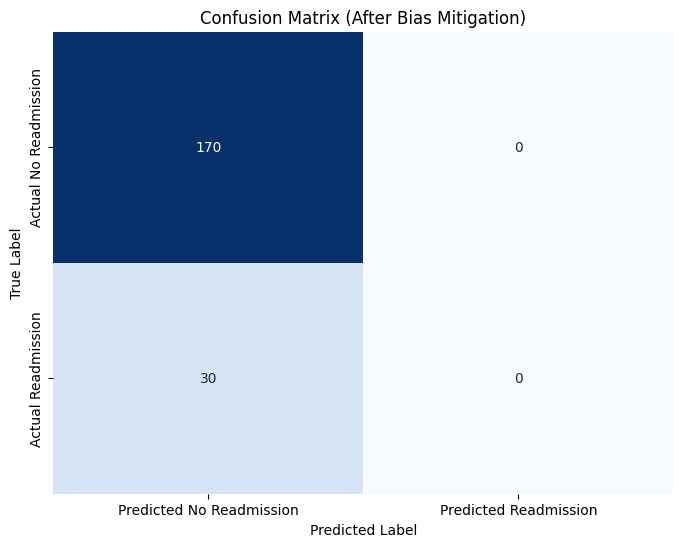

True Negatives (TN): 170
False Positives (FP): 0
False Negatives (FN): 30
True Positives (TP): 0

Metrics calculated from Confusion Matrix:
Precision: 0.000
Recall: 0.000
Accuracy: 0.850


In [2]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the confusion matrix for the mitigated predictions
cm = confusion_matrix(y_test_arr, y_pred_final)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted No Readmission', 'Predicted Readmission'],
            yticklabels=['Actual No Readmission', 'Actual Readmission'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (After Bias Mitigation)')
plt.show()

# Print the confusion matrix values
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

# Calculate metrics from confusion matrix to verify classification report
precision_manual = tp / (tp + fp) if (tp + fp) > 0 else 0
recall_manual = tp / (tp + fn) if (tp + fn) > 0 else 0
accuracy_manual = (tp + tn) / (tp + tn + fp + fn)

print(f"\nMetrics calculated from Confusion Matrix:")
print(f"Precision: {precision_manual:.3f}")
print(f"Recall: {recall_manual:.3f}")
print(f"Accuracy: {accuracy_manual:.3f}")

## 4. Deployment Considerations and Healthcare Regulations

**Deployment Outline:**
1.  **Model Packaging:** The trained `model_pipeline` and the determined optimal threshold for the protected group need to be saved. As done, `joblib` is used to save the pipeline. The threshold value needs to be stored alongside the model artifact or within a custom prediction service.
2.  **Prediction Service:** Deploy the model pipeline as a microservice (e.g., using Flask, FastAPI, or cloud-specific services like Vertex AI Endpoints, AWS SageMaker Endpoints). This service will receive patient data, preprocess it using the saved pipeline, obtain predicted probabilities, and then apply the appropriate threshold (standard for non-protected, optimal for protected) to generate the final prediction.
3.  **Integration:** Integrate the prediction service with the hospital's EHR system or other clinical workflows. This could involve APIs to send patient data to the service and receive predictions, which are then displayed within the clinical interface or used to trigger alerts/tasks for care managers.
4.  **Monitoring:** Implement monitoring for model performance (precision, recall, fairness metrics over time), data drift (changes in input data characteristics), and model drift (degradation in predictive power). Alerts should be set up for significant changes.
5.  **Feedback Loop:** Establish a feedback mechanism to collect actual readmission outcomes and potentially clinician feedback to retrain and improve the model periodically.

**Healthcare Regulations (HIPAA Compliance):**
Integrating an AI model into a healthcare system requires strict adherence to regulations like the Health Insurance Portability and Accountability Act (HIPAA) in the U.S. Key considerations include:
*   **Data De-identification/Anonymization:** While training may require access to PHI, deployment predictions should ideally work with de-identified data where possible, or access to PHI should be strictly controlled.
*   **Access Controls:** Implement robust access controls and authentication mechanisms to ensure only authorized personnel and systems can access the prediction service and the underlying data.
*   **Encryption:** Ensure data is encrypted both in transit (e.g., using TLS/SSL for API calls) and at rest (e.g., encrypted databases or storage).
*   **Auditing:** Maintain audit logs of all access to the model and prediction service, as well as data processing steps, to track usage and identify potential breaches.
*   **Business Associate Agreements (BAAs):** If using third-party cloud services or vendors for deployment, ensure that a BAA is in place, outlining responsibilities for protecting PHI.
*   **Regular Security Assessments:** Conduct regular vulnerability scans and penetration testing of the deployment infrastructure.
*   **Fairness and Transparency:** While not strictly a HIPAA requirement, demonstrating the model's fairness and being able to explain its predictions (as enabled by Logistic Regression) is crucial for trust and ethical deployment in healthcare.

**Combining Model and Thresholds for Deployment:**
A robust deployment artifact might not just be the saved pipeline but a custom class or function that encapsulates both the `model_pipeline` and the logic for applying the group-specific thresholds based on the patient's `insurance_type`.

## 5. Optimization: Addressing Overfitting

**Method: L2 Regularization (Implemented)**
*   **Explanation:** L2 regularization adds a penalty term to the Logistic Regression model's objective function that is proportional to the square of the magnitude of the model coefficients.
*   **How it helps with Overfitting:** By penalizing large coefficients, L2 regularization encourages the model to use smaller weights, effectively smoothing the decision boundary. This makes the model less sensitive to the noise in the training data and improves its ability to generalize to unseen data, thereby reducing the risk of overfitting. The hyperparameter `C` in `LogisticRegression` controls the strength of the regularization (smaller `C` means stronger regularization). The code uses a default `C=1.0`.

**Other Potential Optimization Methods:**
*   **Cross-Validation:** While not strictly an anti-overfitting technique itself, using cross-validation during training helps to get a more reliable estimate of model performance on unseen data and can guide hyperparameter tuning (like selecting the optimal `C` for L2 regularization) to avoid overfitting to a single train-test split.
*   **Feature Selection:** Removing irrelevant or redundant features can simplify the model and reduce the chance of overfitting.
*   **Gathering More Data:** Often the most effective way to combat overfitting is to increase the size and diversity of the training dataset.